

### Generación de Modelos Predictivos con LOGISTIC REGRESSION

Este tipo de modelos requiere una revisión previa de colienalidad.  Tambien permiten obtener información del peso de las variables en el modelo.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Cargar tu DataFrame, reemplaza 'tu_dataframe.csv' con el nombre de tu archivo CSV
dfbase = pd.read_pickle('checkpoints/DATOS_LIMPIOS.pkl')

Cargamos el archivo ya preparado de DATOS_LIMPIOS y separamos las variables independientes en **X** y la dependiente en **y**

In [4]:
df = dfbase.copy()
df = df[df['LABEL']!=-1]

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Supongamos que tienes un DataFrame 'df' con tus datos, donde 'X' son las características y 'y' es la variable objetivo.
# Asegúrate de que 'y' sea una variable binaria (0 o 1) para usar un clasificador de árbol de decisión.

# Dividir el DataFrame en conjuntos de entrenamiento (70%) y prueba (30%)
X = df.drop('LABEL', axis=1)  # Reemplaza 'target_column' con el nombre de tu columna objetivo
y = df['LABEL']  # Reemplaza 'target_column' con el nombre de tu columna objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear un modelo de Árbol de Decisión
modelo_arbol = DecisionTreeClassifier(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
parametros = {
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en un nodo hoja
}

# Crear listas para almacenar los resultados de validación cruzada
resultados_roc_auc = []
resultados_accuracy = []

# Realizar una búsqueda de cuadrícula con validación cruzada (5 folds) para encontrar los mejores hiperparámetros
for params in parametros['max_depth']:
    for split in parametros['min_samples_split']:
        for leaf in parametros['min_samples_leaf']:
            modelo_arbol.set_params(max_depth=params, min_samples_split=split, min_samples_leaf=leaf)
            roc_auc_fold = cross_val_score(modelo_arbol, X_train, y_train, cv=5, scoring='roc_auc')
            accuracy_fold = cross_val_score(modelo_arbol, X_train, y_train, cv=5, scoring='accuracy')
            
            resultados_roc_auc.append(roc_auc_fold.mean())
            resultados_accuracy.append(accuracy_fold.mean())

# Crear un DataFrame con los resultados
resultados_parciales = pd.DataFrame({
    'max_depth': [params for params in parametros['max_depth'] for _ in range(len(parametros['min_samples_split']) * len(parametros['min_samples_leaf']))],
    'min_samples_split': [split for _ in range(len(parametros['max_depth'])) for split in parametros['min_samples_split'] * len(parametros['min_samples_leaf'])],
    'min_samples_leaf': [leaf for _ in range(len(parametros['max_depth']) * len(parametros['min_samples_split'])) for leaf in parametros['min_samples_leaf']],
    'ROC-AUC': resultados_roc_auc,
    'Accuracy': resultados_accuracy
})

print("Resultados parciales de la búsqueda de hiperparámetros:")
print(resultados_parciales)



Resultados parciales de la búsqueda de hiperparámetros:
    max_depth  min_samples_split  min_samples_leaf   ROC-AUC  Accuracy
0         NaN                  2                 1  0.818911  0.859518
1         NaN                  5                 2  0.824984  0.834881
2         NaN                 10                 4  0.827234  0.820837
3         NaN                  2                 1  0.824409  0.854116
4         NaN                  5                 2  0.825906  0.827967
5         NaN                 10                 4  0.827234  0.820837
6         NaN                  2                 1  0.826619  0.843525
7         NaN                  5                 2  0.823391  0.816728
8         NaN                 10                 4  0.827949  0.819754
9        10.0                  2                 1  0.798737  0.798138
10       10.0                  5                 2  0.802418  0.789710
11       10.0                 10                 4  0.821177  0.789495
12       10.0        

In [6]:
resultados_parciales.to_excel('resultados_DT.xlsx')

In [8]:
# Obtener los mejores hiperparámetros encontrados
mejores_parametros = resultados_parciales.iloc[resultados_parciales['ROC-AUC'].idxmax()]

print("Mejores hiperparámetros encontrados:")
print(mejores_parametros)

# Entrenar el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
modelo_arbol_optimizado = DecisionTreeClassifier(max_depth=int(mejores_parametros['max_depth']),
                                                min_samples_split=int(mejores_parametros['min_samples_split']),
                                                min_samples_leaf=int(mejores_parametros['min_samples_leaf']),
                                                random_state=42)
modelo_arbol_optimizado.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predicciones = modelo_arbol_optimizado.predict(X_test)

# Calcular el ROC-AUC final en el conjunto de prueba
roc_auc_final = roc_auc_score(y_test, predicciones)

print("ROC-AUC final en el conjunto de prueba:", roc_auc_final)

Mejores hiperparámetros encontrados:
max_depth            30.000000
min_samples_split     5.000000
min_samples_leaf      2.000000
ROC-AUC               0.832227
Accuracy              0.837476
Name: 28, dtype: float64
ROC-AUC final en el conjunto de prueba: 0.7871532964592838


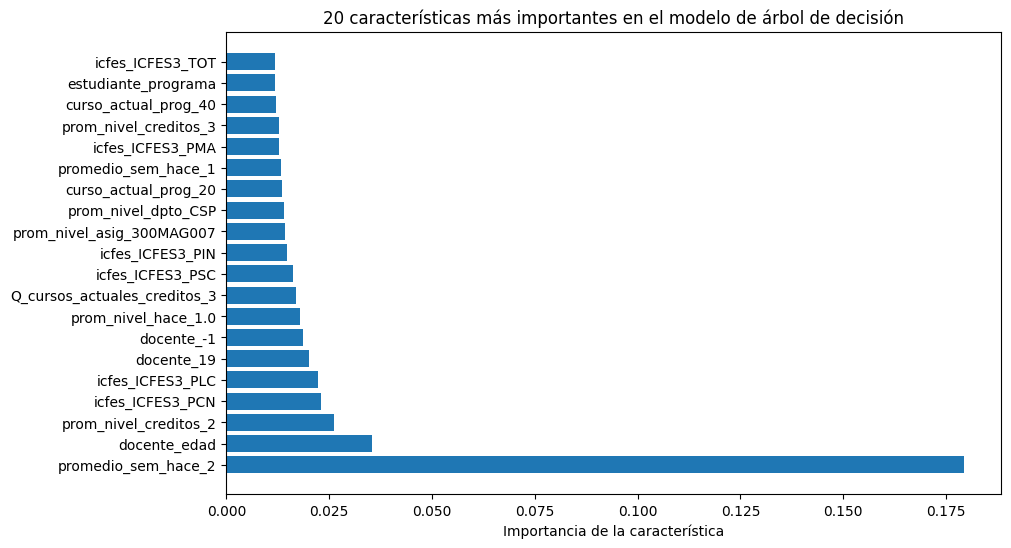

In [10]:
import matplotlib.pyplot as plt

# Extrae la importancia de las características
importancias = modelo_arbol_optimizado.feature_importances_

# Obtén los nombres de las características
nombres_caracteristicas = X.columns  # Asumiendo que estás usando pandas

caracteristicas_importantes = list(zip(nombres_caracteristicas, importancias))

# Ordena la lista de tuplas por importancia en orden descendente
caracteristicas_importantes.sort(key=lambda x: x[1], reverse=True)

# Toma las 20 características más importantes
caracteristicas_top_20 = caracteristicas_importantes[:20]

# Extrae los nombres de las características y las importancias
nombres_top_20 = [c[0] for c in caracteristicas_top_20]
importancias_top_20 = [c[1] for c in caracteristicas_top_20]

# Crea un gráfico de barras horizontal para las 20 características más importantes
plt.figure(figsize=(10, 6))
plt.barh(range(len(importancias_top_20)), importancias_top_20, align='center')
plt.yticks(range(len(importancias_top_20)), nombres_top_20)
plt.xlabel('Importancia de la característica')
plt.title('20 características más importantes en el modelo de árbol de decisión')
plt.show()